# Generates the input histograms to use with TRexFitter
## 1. Gather files from paths.
## 2. Correct Z-QCDjj uncertainty taking into account the uncertainties coming from the RW.
## 3. Create file and upload it to lxplus.

## 1

In [16]:
import ROOT as r
import os
import numpy as np
import matplotlib.pyplot as plt

def channel(path):
    if "MuMu" in path:
        return "Zmumu"
    elif "Zee" in path:
        return "Zee"
    elif "TauTau" in path:
        return "Ztautau"
    else :
        raise ValueError("Path not found")

remotePath = "/afs/cern.ch/work/d/dbaronmo/private/TRexFitter/stat-tutorial/"
localPath = "/Users/diegomac/Documents/HEP/VBF-Analysis/TauTau/AnalysisCrossCheck/"

dataSamples = ['Data.root']
signalSamples = ['Signal_Sherpa.root','Signal_PoPy.root']
qcdSamples = [channel(localPath)+i for i in ["_SherpaRW.root","_MGRW.root","_Average_EW-Sherpa.root","_Average_EW-PoPy.root"]]
backgroundSamples = ['Wjets.root','VV.root',"ttbar.root",'singletop.root']
if "Tau" in localPath:
    backgroundSamples += ['Higgs.root','Zjets.root']
    
samples = dataSamples+signalSamples+qcdSamples+backgroundSamples

## 2

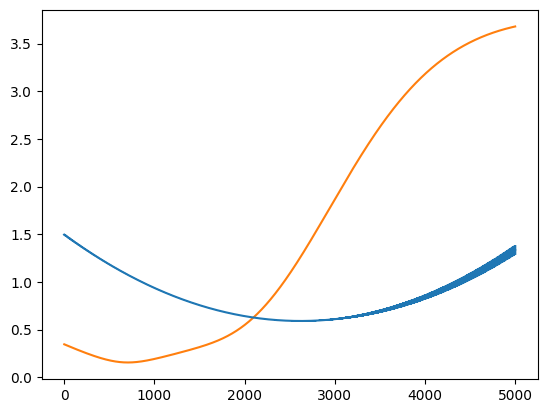

In [17]:
def model_uncern(covariance_matrix,x):
    var_a = covariance_matrix[0][0]
    var_b = covariance_matrix[1][1]
    var_c = covariance_matrix[2][2]
    
    cov_ab = covariance_matrix[0][1]
    cov_ac = covariance_matrix[0][2]
    cov_bc = covariance_matrix[1][2]
    
    diagonal_term = var_a*(x**4) + var_b*(x**2) + var_c
    no_diagonal_term = 2*cov_ab*(x**3) + 2*cov_ac*(x**2) + 2*cov_bc*x
    
    return np.sqrt(diagonal_term+no_diagonal_term)

def parabolic_shape(mjj,parameters):
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    return a*mjj*mjj+b*mjj+c

model_uncer = np.vectorize(model_uncern)
parabolic_shape = np.vectorize(parabolic_shape,excluded=['parameters'])

fitParams = {"Sherpa": [ 1.31867345e-07, -6.91194368e-04,  1.49568233e+00], 
              "MG" : [ 1.35194973e-07, -5.44814667e-04,  9.89623841e-01] }

covarianceMatrix =  {"Sherpa" : [[ 1.19177067e-17, -2.94876918e-14,  1.41446066e-11],
                               [-2.94876918e-14,  8.14817316e-11, -4.30728335e-08],
                               [ 1.41446066e-11, -4.30728335e-08,  2.66545658e-05]],
                    "MG" : [[ 6.10103774e-18, -1.39152060e-14,  6.28353598e-12],
                           [-1.39152060e-14,  3.55524563e-11, -1.77055103e-08],
                           [ 6.28353598e-12, -1.77055103e-08,  1.02381778e-05]]}

x = np.linspace(0,5000,5001)
y = parabolic_shape(x,parameters=fitParams["Sherpa"])
y_error = model_uncern(covarianceMatrix["Sherpa"],x)

percentageError = 100*y_error/y

plt.errorbar(x,y,y_error)
plt.plot(x,percentageError)

In [18]:
def scaleBinUncertainty(histogram,sampleName):
    
    sampleType = "MG"
    if "Sherpa" in sampleName:
        sampleType = "Sherpa"
    
    for i in range(1,histogram.GetNbinsX()+1):
        x = histogram.GetBinCenter(i)
        error = histogram.GetBinError(i)
        rw = parabolic_shape(x,parameters=fitParams[sampleType])
        rw_error = model_uncern(covarianceMatrix[sampleType],x)
        newError = np.sqrt(error**2 + ((rw_error/rw)**2)*(error**2))
        histogram.SetBinError(i,newError)

In [19]:
histogramNames = ["mass_jj"]

outputFile = r.TFile.Open(channel(localPath)+"histograms.root","RECREATE")

for sample in samples:
    for histogramName in histogramNames:
        file = r.TFile.Open(localPath+sample,"READ")
        histogram = file.Get(histogramName)
        
        if "RW" in sample:
            scaleBinUncertainty(histogram,sample)
        
        outputFile.WriteObject(histogram,histogramName+"_"+sample[:-5])
        file.Close()
        
outputFile.Close()

In [20]:
os.system("scp "+channel(localPath)+"histograms.root "+"dbaronmo@lxplus.cern.ch:"+remotePath+".")

0

In [120]:
axis = np.array([ 125.,  375.,  625.,  875., 1125., 1375., 1750., 2250., 2750., 3500., 4500.])
y_error = model_uncern(covarianceMatrix["MG"],axis)
y_error

array([0.00255163, 0.00154236, 0.00101951, 0.00101349, 0.00120375,
       0.00140845, 0.00192416, 0.00367772, 0.00684859, 0.0140738 ,
       0.02812596])